The goal of this notebook is to look into the application information and the credit history of a certain individual so that the we can predict if they are going to be a "good" or "bad" applicant. This is done through cleaning and combining our datasets. Then exploring the data to get a basic understanding of what we are working with. Finally creating models to see how well we can predict the "good" and "bad" applicants.

# Loading data

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Link to the dataset: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data

In [ ]:
app_record_df = pd.read_csv('/content/drive/MyDrive/DS Project Data/application_record.csv')
credit_record_df = pd.read_csv('/content/drive/MyDrive/DS Project Data/credit_record.csv')

# Cleaning

In [ ]:
# Only occupation type has many missing values about 30% of the data
app_record_df.isna().sum() / len(app_record_df)

,0
ID,0.00000
CODE_GENDER,0.00000
FLAG_OWN_CAR,0.00000
FLAG_OWN_REALTY,0.00000
CNT_CHILDREN,0.00000
AMT_INCOME_TOTAL,0.00000
NAME_INCOME_TYPE,0.00000
NAME_EDUCATION_TYPE,0.00000
NAME_FAMILY_STATUS,0.00000
NAME_HOUSING_TYPE,0.00000


In [ ]:
# Nothing is missing from this dataset
credit_record_df.isna().sum() / len(credit_record_df)

,0
ID,0.0
MONTHS_BALANCE,0.0
STATUS,0.0


In [ ]:
app_record_df['CNT_FAM_MEMBERS'] = app_record_df['CNT_FAM_MEMBERS'].astype(int)
app_record_df['AMT_INCOME_TOTAL'] = app_record_df['AMT_INCOME_TOTAL'].astype(int)

In [ ]:
# Changes all unemployed people to zero days worked instead of large random number
app_record_df['DAYS_EMPLOYED'] = app_record_df['DAYS_EMPLOYED'].replace(365243, 0)

In [ ]:
# Updates days employed to now be years to make data easier to understand and positive
app_record_df['YEARS_EMPLOYED'] = (app_record_df['DAYS_EMPLOYED'] / 365).round(2)
app_record_df['YEARS_EMPLOYED'] = app_record_df['YEARS_EMPLOYED'].abs()

In [ ]:
# Dropped days column since we are now using years
app_record_df = app_record_df.drop(columns='DAYS_EMPLOYED')

In [ ]:
# Updates the days born column to now have a real birthdate instead
app_record_df['DAYS_BIRTH'] = app_record_df['DAYS_BIRTH'].abs()
app_record_df['YEARS_ALIVE'] = (app_record_df['DAYS_BIRTH'] / 365).round(2)

In [ ]:
# Dropped DAYS_BIRTH since we now have the year they were born
app_record_df = app_record_df.drop(columns='DAYS_BIRTH')

In [ ]:
app_record_df['FLAG_OWN_CAR'] = app_record_df['FLAG_OWN_CAR'].replace({'N': 0, 'Y': 1})
app_record_df['FLAG_OWN_REALTY'] = app_record_df['FLAG_OWN_REALTY'].replace({'N': 0, 'Y': 1})

<ipython-input-111-a6c009f2e9ee>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  app_record_df['FLAG_OWN_CAR'] = app_record_df['FLAG_OWN_CAR'].replace({'N': 0, 'Y': 1})
<ipython-input-111-a6c009f2e9ee>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  app_record_df['FLAG_OWN_REALTY'] = app_record_df['FLAG_OWN_REALTY'].replace({'N': 0, 'Y': 1})


In [ ]:
# Give us two columns which make better sense
credit_record_df['STATUS'] = credit_record_df['STATUS'].replace({'X': 1, 'C': 1})
credit_record_df['STATUS'] = credit_record_df['STATUS'].replace({'1': 0, '2': 0, '3': 0, '4': 0, '5': 0})

In [ ]:
# Changes to positive for better readibility and workability
credit_record_df['MONTHS_BALANCE'] = credit_record_df['MONTHS_BALANCE'].abs()

# Merging and splitting datasets

Creates the dataset with everyone that has a credit record where we will train and validate the set to learn what to look for in good and bad credit records.

In [ ]:
# Takes only the matching columns in each dataset
both_df = pd.merge(app_record_df, credit_record_df, on='ID', how='inner')

In [ ]:
both_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,YEARS_EMPLOYED,YEARS_ALIVE,MONTHS_BALANCE,STATUS
0,5008804,M,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2,12.44,32.89,0,1
1,5008804,M,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2,12.44,32.89,1,1
2,5008804,M,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2,12.44,32.89,2,1
3,5008804,M,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2,12.44,32.89,3,1
4,5008804,M,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2,12.44,32.89,4,1


In [ ]:
both_df.shape

(777715, 20)

Creates the dataset that we will test the data on later down the road. This has all of the information for the people that do not have credit records aka people that are getting new cards or first timers.

In [ ]:
# Get unique IDs
unique_ids_application = app_record_df['ID'].unique()
unique_ids_credit = credit_record_df['ID'].unique()

# Find IDs that are in application.csv but not in credit.csv
ids_in_application_not_credit = [id for id in unique_ids_application if id not in unique_ids_credit]

# Filter application_df to keep only those rows with IDs not in credit_df
new_df = app_record_df[app_record_df['ID'].isin(ids_in_application_not_credit)]

In [ ]:
both_df['STATUS'] = both_df['STATUS'].astype(int)
# Count total number of records per applicant
total_records = both_df.groupby('ID').size().reset_index(name='TOTAL_RECORDS')

# Count how many times STATUS is 1 (on payment) per applicant
late_payments = both_df.groupby('ID')['STATUS'].sum().reset_index(name='TOTAL_ON_PAYMENTS')

# Merge both counts
payment_stats = total_records.merge(late_payments, on='ID')

# Calculate on-time payment rate
payment_stats['ON_TIME_RATE'] =  (payment_stats['TOTAL_ON_PAYMENTS'] / payment_stats['TOTAL_RECORDS']) * 100

# Display the first few rows
payment_stats.head()

# merge
both_df = both_df.merge(payment_stats, on='ID')
both_df = both_df.drop_duplicates(subset=['ID'])

In [ ]:
both_df = both_df.drop(columns=['MONTHS_BALANCE','STATUS','TOTAL_RECORDS', 'TOTAL_ON_PAYMENTS', 'FLAG_MOBIL'])

In [ ]:
both_df.to_csv('cleaned_credit_data.csv')

In [ ]:
from sklearn.preprocessing import OneHotEncoder

oh_name_education_type = OneHotEncoder(sparse_output=False)

oh_name_education_type.fit(both_df[['NAME_EDUCATION_TYPE']])

oh_name_education_type.transform(both_df[['NAME_EDUCATION_TYPE']])

both_df[both_df['NAME_EDUCATION_TYPE'].unique()] = oh_name_education_type.transform(both_df[['NAME_EDUCATION_TYPE']])

# Exploring the data

(array([ 881., 4248., 4922., 5177., 5015., 4063., 3934., 3715., 3250.,
        1252.]),
 array([20.52 , 25.359, 30.198, 35.037, 39.876, 44.715, 49.554, 54.393,
        59.232, 64.071, 68.91 ]),
 <BarContainer object of 10 artists>)

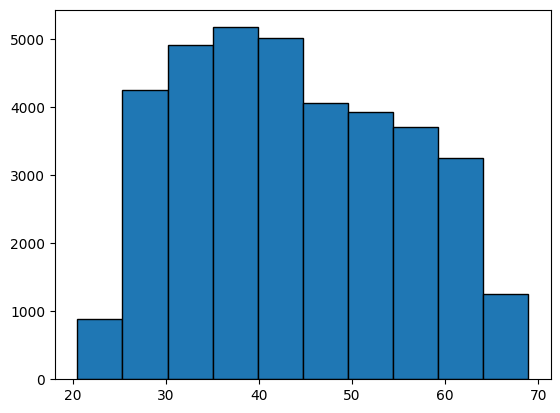

In [ ]:
# Looking how old most of the people in our dataset are
plt.hist(both_df['YEARS_ALIVE'], bins=10, edgecolor="black")

(array([18420.,  8843.,  4588.,  2143.,  1140.,   665.,   363.,   165.,
           73.,    57.]),
 array([ 0.   ,  4.305,  8.61 , 12.915, 17.22 , 21.525, 25.83 , 30.135,
        34.44 , 38.745, 43.05 ]),
 <BarContainer object of 10 artists>)

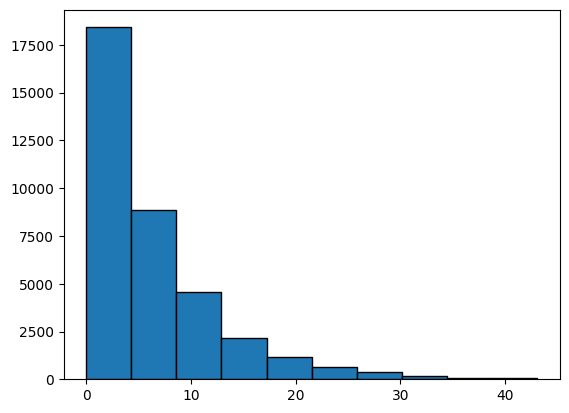

In [ ]:
# Looking how long most of the people in our dataset have worked
plt.hist(both_df['YEARS_EMPLOYED'], bins=10, edgecolor="black")

In [ ]:
both_df['YEARS_EMPLOYED'].describe()

,YEARS_EMPLOYED
count,36457.000000
mean,6.028365
std,6.484368
min,0.000000
25%,1.120000
50%,4.250000
75%,8.640000
max,43.050000


In [ ]:
# Range from $27,000 to $1,575,000
# Average around $180,000
print(both_df['AMT_INCOME_TOTAL'].min())
print(both_df['AMT_INCOME_TOTAL'].max())
print(both_df['AMT_INCOME_TOTAL'].mean().round())

27000
1575000
186686.0


## Grouping the data by if they are good or bad, then exploring

In [ ]:
both_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,OCCUPATION_TYPE,CNT_FAM_MEMBERS,YEARS_EMPLOYED,YEARS_ALIVE,ON_TIME_RATE,Higher education,Secondary / secondary special,Incomplete higher,Lower secondary,Academic degree
0,5008804,M,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,...,NaN,2,12.44,32.89,87.500000,0.0,1.0,0.0,0.0,0.0
16,5008805,M,1,1,0,427500,Working,Higher education,Civil marriage,Rented apartment,...,NaN,2,12.44,32.89,86.666667,0.0,1.0,0.0,0.0,0.0
31,5008806,M,1,1,0,112500,Working,Secondary / secondary special,Married,House / apartment,...,Security staff,2,3.11,58.83,76.666667,0.0,0.0,0.0,0.0,1.0
61,5008808,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,Sales staff,1,8.36,52.36,60.000000,0.0,0.0,0.0,0.0,1.0
66,5008809,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,Sales staff,1,8.36,52.36,100.000000,0.0,0.0,0.0,0.0,1.0


In [ ]:
both_df['ON_TIME'] = both_df['ON_TIME_RATE'].apply(lambda x: 1 if x >  75 else 0)

In [ ]:
both_df['ON_TIME'].value_counts()

,count
ON_TIME,
0,24498
1,11959


In [ ]:
# Significantly more females within each category
both_df.groupby('ON_TIME')['CODE_GENDER'].value_counts()

ON_TIME  CODE_GENDER
0        F              16490
         M               8008
1        F               7940
         M               4019
Name: count, dtype: int64

In [ ]:
both_df.groupby('ON_TIME')['YEARS_EMPLOYED'].mean()

,YEARS_EMPLOYED
ON_TIME,
0,5.989273
1,6.108445


In [ ]:
both_df.groupby('ON_TIME')['YEARS_ALIVE'].mean()

,YEARS_ALIVE
ON_TIME,
0,43.838704
1,43.621978


In [ ]:
# Both groups make about the same average income
both_df.groupby('ON_TIME')['AMT_INCOME_TOTAL'].mean()

,AMT_INCOME_TOTAL
ON_TIME,
0,186802.572128
1,186446.397441


In [ ]:
both_df.groupby('ON_TIME')['FLAG_OWN_CAR'].value_counts()

ON_TIME  FLAG_OWN_CAR
0        0               15338
         1                9160
1        0                7276
         1                4683
Name: count, dtype: int64

# First Decision Tree Model

In [ ]:
# Splitting into the testing and validating sets
from sklearn.model_selection import train_test_split

test_df, validation_df = train_test_split(new_df, train_size=0.5, test_size=0.5)

In [ ]:
# The training df will be the both_df
training_df = both_df

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

In [ ]:
validation_df['ON_TIME'] = 0

In [ ]:
validation_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,YEARS_EMPLOYED,YEARS_ALIVE,ON_TIME
419857,6836942,F,0,1,0,180000,Working,Secondary / secondary special,Single / not married,House / apartment,1,0,0,0,Laborers,1,2.58,24.83,0
136115,5820509,M,1,0,1,202500,Working,Secondary / secondary special,Married,With parents,1,0,0,0,NaN,3,6.42,30.18,0
356902,6481169,M,0,1,1,360000,Commercial associate,Incomplete higher,Married,House / apartment,1,0,0,1,NaN,3,6.64,29.81,0
211348,5938655,F,0,0,1,112500,State servant,Secondary / secondary special,Married,House / apartment,1,0,1,1,High skill tech staff,3,9.99,42.04,0
349690,6430940,F,1,1,0,225000,Working,Higher education,Civil marriage,House / apartment,1,1,0,0,NaN,2,3.41,40.64,0


<Axes: xlabel='ON_TIME', ylabel='ON_TIME tree preds'>

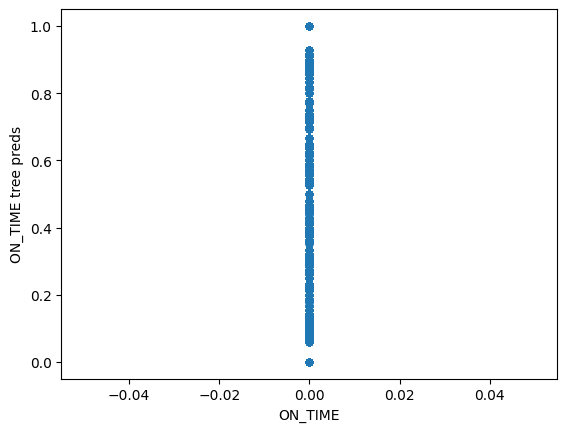

In [ ]:
# Setting up the X and y
X_train = training_df[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE']]
y_train = training_df['ON_TIME']

X_valid = validation_df[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE']]
y_valid = validation_df['ON_TIME']

# Fit model with the training data
tree.fit(X_train, y_train)

# Make predictions on the validation data
preds_validation = tree.predict_proba(X_valid)[:, 1]

# Save predictions
validation_df['ON_TIME tree preds'] = preds_validation

# Make scatterplot for actual vs predicted
validation_df.plot('ON_TIME', 'ON_TIME tree preds', kind='scatter')

In [ ]:
validation_df['ON_TIME tree preds']

,ON_TIME tree preds
419857,0.166667
136115,0.400000
356902,1.000000
211348,0.000000
349690,0.000000
...,...
64352,1.000000
341318,0.000000
78922,1.000000
209149,0.000000


In [ ]:
validation_df['ON_TIME tree preds'].value_counts()

,count
ON_TIME tree preds,
0.000000,94708
1.000000,34691
0.500000,14836
0.333333,7435
0.666667,6342
...,...
0.210526,4
0.176471,4
0.380952,3


In [ ]:
probs = tree.predict_proba(X_valid)

In [ ]:
y_train.unique()

array([1, 0])

In [ ]:
# Proability of them being a bad customer, Probability of them being a person that pays on time and is a good customer
validation_df['tree probs'] = probs[:, 1]

In [ ]:
validation_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,YEARS_EMPLOYED,YEARS_ALIVE,ON_TIME,ON_TIME tree preds,tree probs
419857,6836942,F,0,1,0,180000,Working,Secondary / secondary special,Single / not married,House / apartment,...,0,0,0,Laborers,1,2.58,24.83,0,0.166667,0.166667
136115,5820509,M,1,0,1,202500,Working,Secondary / secondary special,Married,With parents,...,0,0,0,NaN,3,6.42,30.18,0,0.400000,0.400000
356902,6481169,M,0,1,1,360000,Commercial associate,Incomplete higher,Married,House / apartment,...,0,0,1,NaN,3,6.64,29.81,0,1.000000,1.000000
211348,5938655,F,0,0,1,112500,State servant,Secondary / secondary special,Married,House / apartment,...,0,1,1,High skill tech staff,3,9.99,42.04,0,0.000000,0.000000
349690,6430940,F,1,1,0,225000,Working,Higher education,Civil marriage,House / apartment,...,1,0,0,NaN,2,3.41,40.64,0,0.000000,0.000000


In [ ]:
# This shows that Income, Years Employed, and Years alive are the three most important factors for determining if they are going to be a good applicant
importances = tree.feature_importances_

# Display feature importance
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {(importance * 100):.4f}")

FLAG_OWN_CAR: 2.6001
FLAG_OWN_REALTY: 3.2135
CNT_CHILDREN: 2.5007
AMT_INCOME_TOTAL: 16.7054
FLAG_WORK_PHONE: 2.2979
FLAG_PHONE: 2.9493
FLAG_EMAIL: 1.9160
CNT_FAM_MEMBERS: 4.3833
YEARS_EMPLOYED: 27.8859
YEARS_ALIVE: 35.5479


In [ ]:
validation_df[validation_df['ON_TIME'] != validation_df['ON_TIME tree preds']]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,YEARS_EMPLOYED,YEARS_ALIVE,ON_TIME,ON_TIME tree preds,tree probs
419857,6836942,F,0,1,0,180000,Working,Secondary / secondary special,Single / not married,House / apartment,...,0,0,0,Laborers,1,2.58,24.83,0,0.166667,0.166667
136115,5820509,M,1,0,1,202500,Working,Secondary / secondary special,Married,With parents,...,0,0,0,NaN,3,6.42,30.18,0,0.400000,0.400000
356902,6481169,M,0,1,1,360000,Commercial associate,Incomplete higher,Married,House / apartment,...,0,0,1,NaN,3,6.64,29.81,0,1.000000,1.000000
73199,5271479,M,0,0,0,202500,Working,Secondary / secondary special,Single / not married,House / apartment,...,0,0,0,Laborers,1,7.24,34.60,0,0.625000,0.625000
150651,5709366,F,0,0,0,112500,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,1,0,NaN,2,0.00,51.53,0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157242,5738208,M,1,1,1,135000,Working,Secondary / secondary special,Married,House / apartment,...,1,1,0,Drivers,3,11.71,38.47,0,0.833333,0.833333
162179,5761157,F,0,0,1,72000,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Security staff,3,12.52,45.09,0,0.125000,0.125000
417719,6824474,M,1,0,0,180000,Working,Higher education,Married,House / apartment,...,0,0,0,Managers,2,5.45,43.17,0,1.000000,1.000000
64352,5223684,M,1,0,1,360000,Working,Higher education,Married,House / apartment,...,0,0,0,Managers,3,7.35,29.82,0,1.000000,1.000000


In [ ]:
validation_df[validation_df['ON_TIME tree preds'] == 0]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,YEARS_EMPLOYED,YEARS_ALIVE,ON_TIME,ON_TIME tree preds,tree probs
211348,5938655,F,0,0,1,112500,State servant,Secondary / secondary special,Married,House / apartment,...,0,1,1,High skill tech staff,3,9.99,42.04,0,0.0,0.0
349690,6430940,F,1,1,0,225000,Working,Higher education,Civil marriage,House / apartment,...,1,0,0,NaN,2,3.41,40.64,0,0.0,0.0
252918,6054593,M,1,0,0,135000,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,1,0,NaN,2,0.00,65.22,0,0.0,0.0
270301,6089276,F,1,1,3,247500,State servant,Secondary / secondary special,Married,House / apartment,...,0,0,0,Medicine staff,5,13.66,34.42,0,0.0,0.0
140728,6798376,F,0,1,0,112500,Pensioner,Secondary / secondary special,Married,House / apartment,...,0,0,0,NaN,2,0.00,58.81,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277436,6108578,F,0,1,0,247500,State servant,Higher education,Married,House / apartment,...,0,0,0,Core staff,2,29.00,58.84,0,0.0,0.0
240253,6021255,F,1,1,1,126000,Working,Incomplete higher,Married,House / apartment,...,0,0,0,NaN,3,5.62,34.98,0,0.0,0.0
341318,6403873,F,1,0,0,180000,Pensioner,Incomplete higher,Single / not married,House / apartment,...,0,0,0,NaN,1,0.00,60.56,0,0.0,0.0
209149,5931846,M,0,1,0,157500,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,High skill tech staff,2,4.57,37.67,0,0.0,0.0


In [ ]:
validation_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,YEARS_EMPLOYED,YEARS_ALIVE,ON_TIME,ON_TIME tree preds,tree probs
419857,6836942,F,0,1,0,180000,Working,Secondary / secondary special,Single / not married,House / apartment,...,0,0,0,Laborers,1,2.58,24.83,0,0.166667,0.166667
136115,5820509,M,1,0,1,202500,Working,Secondary / secondary special,Married,With parents,...,0,0,0,NaN,3,6.42,30.18,0,0.400000,0.400000
356902,6481169,M,0,1,1,360000,Commercial associate,Incomplete higher,Married,House / apartment,...,0,0,1,NaN,3,6.64,29.81,0,1.000000,1.000000
211348,5938655,F,0,0,1,112500,State servant,Secondary / secondary special,Married,House / apartment,...,0,1,1,High skill tech staff,3,9.99,42.04,0,0.000000,0.000000
349690,6430940,F,1,1,0,225000,Working,Higher education,Civil marriage,House / apartment,...,1,0,0,NaN,2,3.41,40.64,0,0.000000,0.000000


Text(0.5, 1.0, 'Distribution of Predicted Probabilities')

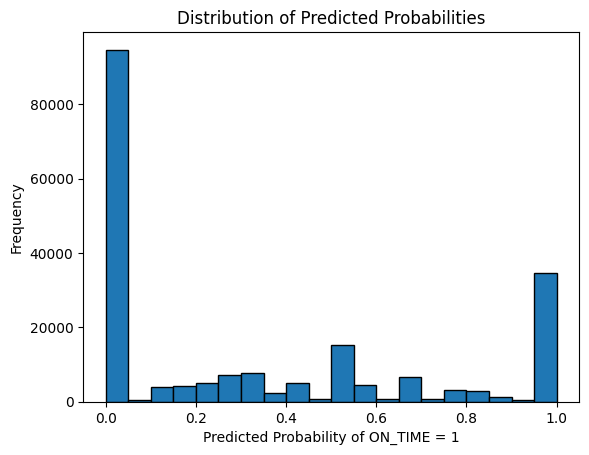

In [ ]:
import matplotlib.pyplot as plt

# Get probability predictions
validation_df['ON_TIME tree prob'] = tree.predict_proba(X_valid)[:, 1]

# Plot histogram of predicted probabilities
plt.hist(validation_df['ON_TIME tree prob'], bins=20, edgecolor="black")
plt.xlabel("Predicted Probability of ON_TIME = 1")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")

In [ ]:
X_test = test_df

In [ ]:
X_test.shape

(201050, 18)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Split training data into a train and test set
X_train_sub, X_test, y_train_sub, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train a new tree model
tree.fit(X_train_sub, y_train_sub)

# Make predictions on test set
preds_test = tree.predict(X_test)
probs_test = tree.predict_proba(X_test)[:, 1]


# Evaluate accuracy and AUC
print(f"Test Accuracy: {accuracy_score(y_test, preds_test):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, probs_test):.4f}")

Test Accuracy: 0.7135
Test AUC: 0.7155


In [ ]:
special_df = pd.DataFrame({
    'preds_test': preds_test,
    'probs_test': probs_test
})

In [ ]:
special_df

,preds_test,probs_test
0,0,0.250000
1,0,0.200000
2,0,0.000000
3,0,0.166667
4,1,0.600000
...,...,...
7287,0,0.500000
7288,1,1.000000
7289,0,0.000000
7290,0,0.500000


In [ ]:
special_df[(special_df['preds_test'] == 0) & (special_df['probs_test'] == 0.5)]

,preds_test,probs_test
8,0,0.5
25,0,0.5
26,0,0.5
27,0,0.5
39,0,0.5
...,...,...
7229,0,0.5
7268,0,0.5
7274,0,0.5
7287,0,0.5


<ipython-input-157-cd62d2c9f575>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tree.predict_proba(X_train)[:,1], label="Training Data", shade=True)
<ipython-input-157-cd62d2c9f575>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(validation_df['ON_TIME tree prob'], label="Validation Data", shade=True)


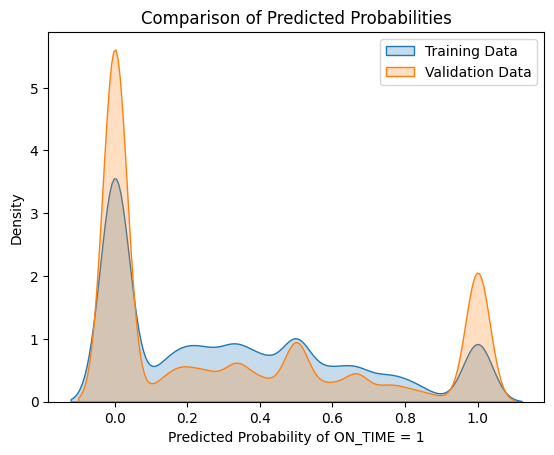

In [ ]:
import seaborn as sns

# Compare probability distributions
sns.kdeplot(tree.predict_proba(X_train)[:,1], label="Training Data", shade=True)
sns.kdeplot(validation_df['ON_TIME tree prob'], label="Validation Data", shade=True)
plt.legend()
plt.xlabel("Predicted Probability of ON_TIME = 1")
plt.title("Comparison of Predicted Probabilities")
plt.show()


In [ ]:
Train_df, Test_df = train_test_split(both_df, train_size=0.7, test_size=0.3)

In [ ]:
X_train = Train_df[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE']]
y_train = Train_df['ON_TIME']

X_test = Test_df[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE']]
y_test = Test_df['ON_TIME']

# Train a new tree model
tree.fit(X_train, y_train)

# Make predictions on test set
preds_test = tree.predict(X_test)
probs_test = tree.predict_proba(X_test)[:, 1]


# Evaluate accuracy and AUC
print(f"Test Accuracy: {accuracy_score(y_test, preds_test):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, probs_test):.4f}")

Test Accuracy: 0.6993
Test AUC: 0.6945


In [ ]:
test_pred = tree.predict(X_test)

for i in range(10):
    # We use [i] for test_pred because it's a list (actually a numpy array, basically the same thing)
    # We use .iloc[i] for y_test because it's a Pandas Series/DataFrame
    print(f'Predicted = {test_pred[i]}, Actual = {y_test.iloc[i]}')

Predicted = 0, Actual = 0
Predicted = 0, Actual = 0
Predicted = 0, Actual = 0
Predicted = 0, Actual = 1
Predicted = 0, Actual = 0
Predicted = 0, Actual = 0
Predicted = 0, Actual = 0
Predicted = 1, Actual = 1
Predicted = 1, Actual = 1
Predicted = 0, Actual = 0


In [ ]:
test_pred_proba = tree.predict_proba(X_test)

for i in range(5):
    # We use [i] for test_pred because it's a list (actually a numpy array, basically the same thing)
    # We use .iloc[i] for y_test because it's a Pandas Series/DataFrame
    print(f'Predicted: P("No") = {test_pred_proba[i][0]:.3f}, P("Yes") = {test_pred_proba[i][1]:.3f}, Actual = {y_test.iloc[i]}')

Predicted: P("No") = 1.000, P("Yes") = 0.000, Actual = 0
Predicted: P("No") = 1.000, P("Yes") = 0.000, Actual = 0
Predicted: P("No") = 1.000, P("Yes") = 0.000, Actual = 0
Predicted: P("No") = 0.500, P("Yes") = 0.500, Actual = 1
Predicted: P("No") = 1.000, P("Yes") = 0.000, Actual = 0


In [ ]:
correct = 0
for i in range(y_test.shape[0]):
    if test_pred[i] == y_test.iloc[i]:
        correct += 1

print(f'Correct {correct} times ({100 * correct / y_test.shape[0]:.2f}%)')

Correct 7649 times (69.93%)


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_pred)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

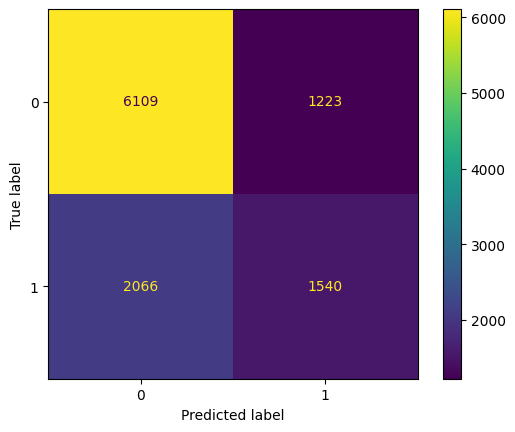

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score

# Assuming y_test contains the true labels, and preds_test contains the model's predictions
accuracy = accuracy_score(y_test, preds_test)
cm = confusion_matrix(y_test, preds_test)

# Extract values from confusion matrix
TN, FP, FN, TP = cm.ravel()

# Compute the required metrics
true_positive_rate = TP / (TP + FN)  # Same as Recall
true_negative_rate = TN / (TN + FP)
false_positive_rate = FP / (FP + TN)
false_negative_rate = FN / (FN + TP)

precision = precision_score(y_test, preds_test)
recall = recall_score(y_test, preds_test)  # Same as TPR
auroc = roc_auc_score(y_test, probs_test)  # probs_test should contain predicted probabilities

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (Recall): {true_positive_rate:.4f}")
print(f"True Negative Rate: {true_negative_rate:.4f}")
print(f"False Positive Rate: {false_positive_rate:.4f}")
print(f"False Negative Rate: {false_negative_rate:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")


Accuracy: 0.6993
True Positive Rate (Recall): 0.4271
True Negative Rate: 0.8332
False Positive Rate: 0.1668
False Negative Rate: 0.5729
Precision: 0.5574
Recall: 0.4271
AUROC: 0.6945


# Final Decision tree model

In [ ]:
both_df['ON_TIME'] = both_df['ON_TIME_RATE'].apply(lambda x: 1 if x >  75 else 0)

In [ ]:
both_df = both_df.drop(columns=['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',  'CODE_GENDER'])

In [ ]:
Train_df, Test_df = train_test_split(both_df, train_size=0.7, test_size=0.3, random_state=42)

In [ ]:
Train_df['EMPLOYMENT_STABILITY'] = Train_df['YEARS_EMPLOYED'] / Train_df['YEARS_ALIVE']
Test_df['EMPLOYMENT_STABILITY'] = Test_df['YEARS_EMPLOYED'] / Test_df['YEARS_ALIVE']

In [ ]:
Train_df['INCOME_PER_CHILD'] = Train_df['AMT_INCOME_TOTAL'] / (Train_df['CNT_CHILDREN'] + 1)
Test_df['INCOME_PER_CHILD'] = Test_df['AMT_INCOME_TOTAL'] / (Test_df['CNT_CHILDREN'] + 1)

In [ ]:
Train_df['OWNS_CAR_AND_REALTY'] = (Train_df['FLAG_OWN_CAR'] & Train_df['FLAG_OWN_REALTY']).astype(int)
Test_df['OWNS_CAR_AND_REALTY'] = (Test_df['FLAG_OWN_CAR'] & Test_df['FLAG_OWN_REALTY']).astype(int)

In [ ]:
Train_df['HAS_CONTACT_INFO'] = (Train_df['FLAG_WORK_PHONE'] + Train_df['FLAG_PHONE'] + Train_df['FLAG_EMAIL']) > 0
Test_df['HAS_CONTACT_INFO'] = (Test_df['FLAG_WORK_PHONE'] + Test_df['FLAG_PHONE'] + Test_df['FLAG_EMAIL']) > 0

In [ ]:
Validation_df, Test_df = train_test_split(Test_df, train_size=0.5, test_size=0.5, random_state=42)

In [ ]:
Validation_df.shape

(5469, 22)

In [ ]:
Train_df.shape

(25519, 22)

In [ ]:
# Creates the training and validation model
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(min_samples_split=5,max_depth=50,
    class_weight='balanced',
    random_state=42
)

X_train = Train_df[[
       'AMT_INCOME_TOTAL', 'FLAG_OWN_REALTY',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE',]]
y_train = Train_df['ON_TIME']

X_validation = Validation_df[[
       'AMT_INCOME_TOTAL', 'FLAG_OWN_REALTY',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE']]
y_validation = Validation_df['ON_TIME']

# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a new tree model
tree.fit(X_train, y_train)

# Make predictions on test set
preds_test = tree.predict(X_validation)
probs_test = tree.predict_proba(X_validation)[:, 1]

Validation_df['test_preds'] = preds_test


# Evaluate accuracy and AUC
print(f"Test Accuracy: {accuracy_score(y_validation, preds_test):.4f}")
print(f"Test AUC: {roc_auc_score(y_validation, probs_test):.4f}")

Test Accuracy: 0.6542
Test AUC: 0.7104


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.4f}")

Mean Cross-Validation AUC: 0.6789


In [ ]:
from sklearn.tree import export_graphviz
import graphviz
import re

dot_data = export_graphviz(tree, out_file=None,
                           feature_names=X_train.columns,
                           class_names=["Late", "On Time"],
                           filled=True, rounded=True,
                           max_depth=3, impurity=False)

filtered_dot_data = re.sub(r'value = \[.*?\]\\n', '', dot_data)
graph = graphviz.Source(filtered_dot_data)
graph.render("tree4")

'tree4.pdf'

In [ ]:
# Creates the testing tree model
X_train = Train_df[['FLAG_OWN_CAR', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'FLAG_OWN_REALTY',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE',]]
y_train = Train_df['ON_TIME']

X_test = Test_df[['FLAG_OWN_CAR', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'FLAG_OWN_REALTY',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE']]
y_test = Test_df['ON_TIME']

tree.fit(X_train, y_train)
preds_test = tree.predict(X_test)
probs_test = tree.predict_proba(X_test)[:, 1]

Test_df['test_preds'] = preds_test

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score

# Assuming y_test contains the true labels, and preds_test contains the model's predictions
accuracy = accuracy_score(y_validation, preds_test)
cm = confusion_matrix(y_validation, preds_test)

# Extract values from confusion matrix
TN, FP, FN, TP = cm.ravel()

# Compute the required metrics
true_positive_rate = TP / (TP + FN)  # Same as Recall
true_negative_rate = TN / (TN + FP)
false_positive_rate = FP / (FP + TN)
false_negative_rate = FN / (FN + TP)

precision = precision_score(y_validation, preds_test)
recall = recall_score(y_validation, preds_test)  # Same as TPR
auroc = roc_auc_score(y_validation, probs_test)  # probs_test should contain predicted probabilities

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (Recall): {true_positive_rate:.4f}")
print(f"True Negative Rate: {true_negative_rate:.4f}")
print(f"False Positive Rate: {false_positive_rate:.4f}")
print(f"False Negative Rate: {false_negative_rate:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")

Accuracy: 0.5080
True Positive Rate (Recall): 0.4589
True Negative Rate: 0.5320
False Positive Rate: 0.4680
False Negative Rate: 0.5411
Precision: 0.3252
Recall: 0.4589
AUROC: 0.5030


Text(0.5, 1.0, 'Feature Importance in DecisionTreeClassifier')

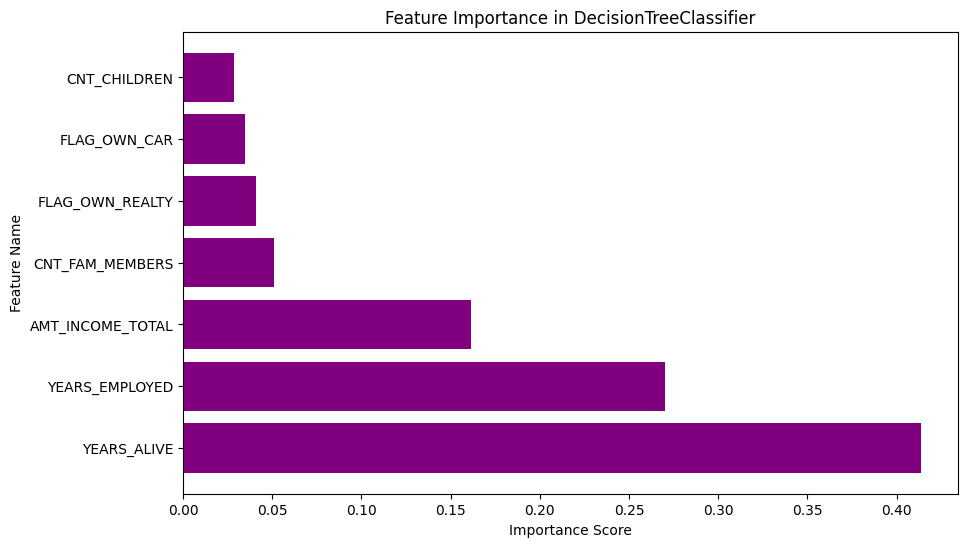

In [ ]:
feature_importances = tree.feature_importances_

feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='purple')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance in DecisionTreeClassifier')



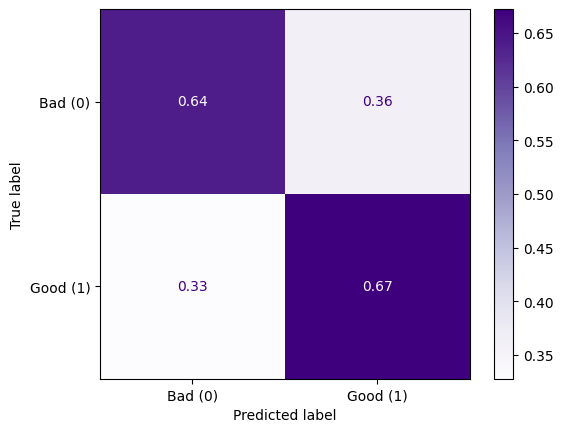

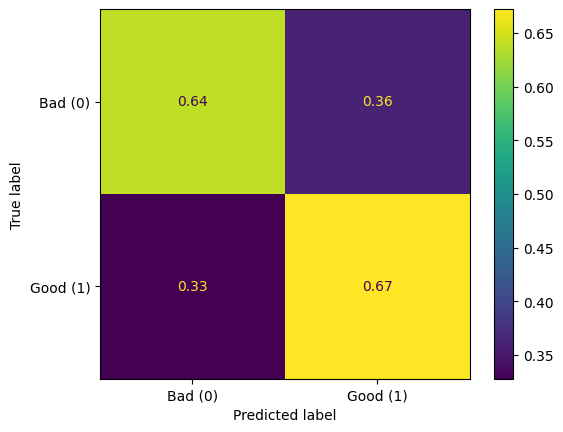

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds_test,  normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Bad (0)', 'Good (1)'])
disp.plot(cmap="Purples")
disp.plot()
plt.show()

In [ ]:
true_positives = Validation_df[(Validation_df['ON_TIME'] == 1) & (Validation_df['test_preds'] == 1)]

<ipython-input-185-cceea1e53270>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=true_positives[feature].value_counts().index,
<ipython-input-185-cceea1e53270>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=true_positives[feature].value_counts().index,


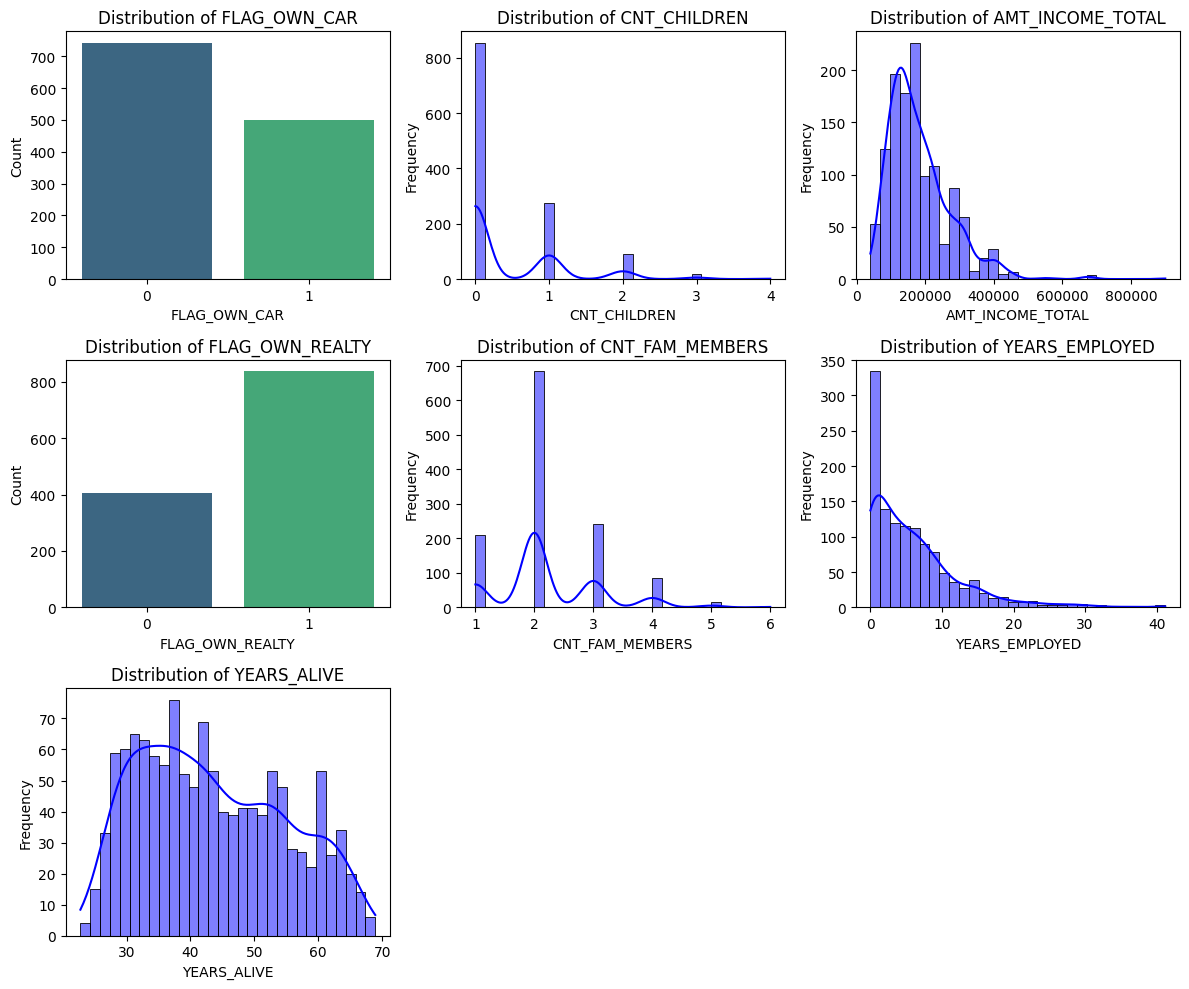

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features to analyze
features = ['FLAG_OWN_CAR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_OWN_REALTY',
            'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE']

# Set the figure size for multiple plots
plt.figure(figsize=(12, 10))

# Loop through each feature and create appropriate plots
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)  # Adjust grid layout as needed

    if true_positives[feature].nunique() == 2:  # Binary categorical feature
        sns.barplot(x=true_positives[feature].value_counts().index,
                    y=true_positives[feature].value_counts().values, palette='viridis')
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.title(f'Distribution of {feature}')

    else:  # Continuous feature
        sns.histplot(true_positives[feature], kde=True, bins=30, color='blue')
        plt.xlabel(feature)
        plt.ylabel("Frequency")
        plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()


In [ ]:
Validation_df['FLAG_OWN_REALTY'].value_counts(normalize=True)

,proportion
FLAG_OWN_REALTY,
1,0.672518
0,0.327482


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

X_train = Train_df[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE']]
y_train = Train_df['ON_TIME']

X_test = Validation_df[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE']]
y_test = Validation_df['ON_TIME']

# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

logr.fit(X_train, y_train)

# Make predictions on test set
preds_test = logr.predict(X_test)
probs_test = logr.predict_proba(X_test)[:, 1]

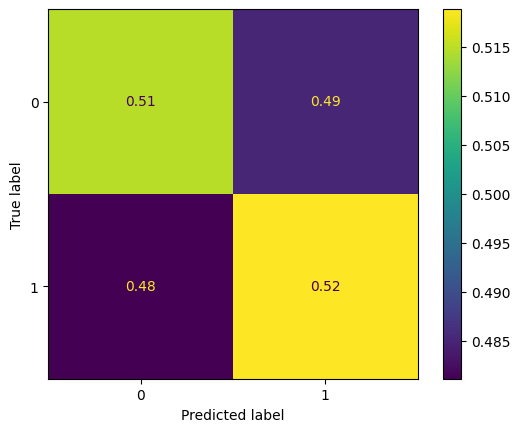

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds_test,  normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=30, class_weight='balanced', random_state=42)

X_train = Train_df[[
       'AMT_INCOME_TOTAL', 'FLAG_OWN_REALTY',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE',]]

y_train = Train_df['ON_TIME']

X_test = Test_df[[
       'AMT_INCOME_TOTAL', 'FLAG_OWN_REALTY',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE',]]
y_test = Test_df['ON_TIME']

# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a new tree model
rf.fit(X_train, y_train)

preds_test = rf.predict(X_test)
probs_test = rf.predict_proba(X_test)[:, 1]

print(f"Test Accuracy: {accuracy_score(y_test, preds_test):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, probs_test):.4f}")

Test Accuracy: 0.6829
Test AUC: 0.7157


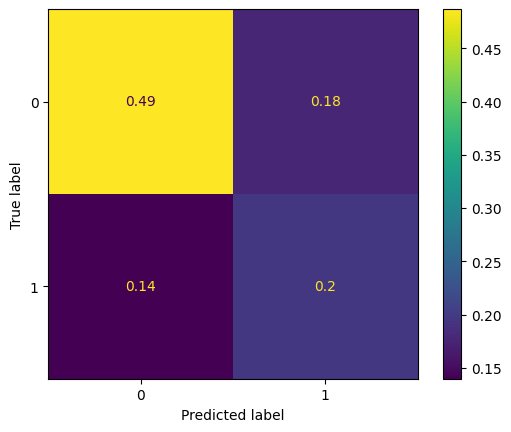

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds_test,  normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()
plt.show()

# XG Boost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


X_train = Train_df[[
       'AMT_INCOME_TOTAL', 'FLAG_OWN_REALTY',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE',]]

y_train = Train_df['ON_TIME']

X_test = Test_df[[
       'AMT_INCOME_TOTAL', 'FLAG_OWN_REALTY',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'YEARS_ALIVE',]]
y_test = Test_df['ON_TIME']

xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Accuracy: 0.7041506673980618
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      3633
           1       0.60      0.36      0.45      1836

    accuracy                           0.70      5469
   macro avg       0.66      0.62      0.62      5469
weighted avg       0.69      0.70      0.68      5469



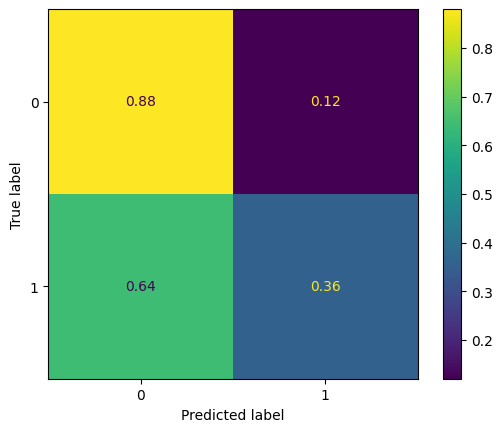

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_xgb,  normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()
plt.show()